In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from natsort import natsorted

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.misc import index_to_sample_df, downsample_raw_input, read_tRNAdb_info, sample_df_to_dict
from src.read_processing import AR_merge, BC_split, Kmer_analysis, BC_analysis, UMI_trim
from src.alignment import SWIPE_align
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.transcript_mutations import TM_analysis

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
seq_dir = 'raw_fastq'
seq_dir_noDS = seq_dir # Not downsampled

# These folder names are used in subsequent processing steps
# to dump data. Best to not change:
AdapterRemoval_dir = 'AdapterRemoval'
BC_dir = 'BC_split'
UMI_dir = 'UMI_trimmed'
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'
tRNA_database = dict()
tRNA_database['human'] = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_database_masked = dict()
tRNA_database_masked['human'] = '{}/tRNA_database_masked/human/human-tRNAs.fa'.format(homedir)
# Read information (length, codon etc) of tRNAs into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_database)
SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)
SWIPE_score_mat2 = '{}/utils/nuc_score-matrix_2.txt'.format(homedir) # For masked reference sequences
# tRNA sequencing yields many duplicated reads.
# Adding these commonly seen sequences to a list prevents duplicated alignment:
common_seqs = '{}/utils/common-seqs.fasta.bz2'.format(homedir)

# Define minimum read length based on minimum insert size:
MIN_INSERT_LEN = 10
UMI_LEN = 10
BC_MAX_LEN = 19
MIN_READ_LEN = MIN_INSERT_LEN + UMI_LEN + BC_MAX_LEN
print('Using minimum read length: {} (after merge)'.format(MIN_READ_LEN))

# Read index information:
index_list_fnam = 'index_list.xlsx'
index_df = pd.read_excel('{}/utils/{}'.format(homedir, index_list_fnam))

Notebook is in: /home/sulab/tRNA-charge-seq/projects/tRNAseq_mtests
Repo is in: /home/sulab/tRNA-charge-seq
Using minimum read length: 39 (after merge)


In [3]:
### Input settings ###
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Add barcode sequences:
sample_df = index_to_sample_df(sample_df, index_df)
# Read elementary info (replicate, barcode, species)
# for each unique sample name into a dictionary:
sample_dict = sample_df_to_dict(sample_df)
# Get filenames from the sample information:
inp_file_df = sample_df[['fastq_mate1_filename', 'fastq_mate2_filename', 'P5_index', 'P7_index', 'P5_index_seq', 'P7_index_seq']].copy().drop_duplicates().reset_index(drop=True)

# Downsample:
if False:
    sample_df, inp_file_df, seq_dir = downsample_raw_input(sample_df, inp_file_df, NBdir, data_dir, seq_dir_noDS, downsample_absolute=1e4)

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                seq_dir = seq_dir,
                AdapterRemoval_dir = AdapterRemoval_dir,
                BC_dir = BC_dir,
                UMI_dir = UMI_dir,
                align_dir = align_dir,
                stats_dir = stats_dir,
                TM_dir = TM_dir,
                plotting_dir = plotting_dir)

In [ ]:
### Run AdapterRemoval ###
AR_obj = AR_merge(dir_dict, inp_file_df, MIN_READ_LEN, overwrite_dir=True)
inp_file_df = AR_obj.run_parallel(n_jobs=4, overwrite=True)

In [5]:
### Split files based on barcodes ###
BCsplit_obj = BC_split(dir_dict, sample_df, inp_file_df, overwrite_dir=True)
sample_df, inp_file_df = BCsplit_obj.run_parallel(n_jobs=12, load_previous=False)

In [6]:
### Generate UMI stats and write final trimmed tRNA sequences ###
UMItrim_obj = UMI_trim(dir_dict, sample_df, overwrite_dir=True)
sample_df = UMItrim_obj.run_parallel(n_jobs=12, load_previous=False)
sample_df.head(3)

Downsampling UMI trimmed sequences to maximum 2000000 reads.


,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_after_downsample
0,100p1_v1,100p,1,2022-12-28/P1_R1.fastq.bz2,2022-12-28/P1_R2.fastq.bz2,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,4882132,223686,4625313,4848999,99.321342,95.386965,4801242,515447,524232.734694,98.343142,98.324077,2000000
1,100p3_v2,100p,3,2022-12-28/P3_R1.fastq.bz2,2022-12-28/P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,3002182,149797,2828358,2978155,99.199682,94.970141,2951295,492415,522404.960362,98.304999,94.259250,2000000
2,0m_p1_v2,100p_0m,1,2023-02-28/P4_R1.fastq.bz2,2023-02-28/P4_R2.fastq.bz2,D502,D701,l5Sp,human,Charge-titration,Percent charge,100p_0m,2,GCCTCTAT,ATTACTCG,GGCTGCCATGCAACGCATC,2989786,163317,2798797,2962114,99.074449,94.486471,2932113,494661,522334.790150,98.070999,94.701906,2000000


In [6]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_database_masked, sample_df, SWIPE_score_mat2, \
                        gap_penalty=6, extension_penalty=3, min_score_align=15, \
                        common_seqs=common_seqs, overwrite_dir=False, check_input=False)
sample_df = align_obj.run_parallel(n_jobs=6, overwrite=False, load_previous=True)
sample_df.head(3)

Using common sequences to prevent duplicated alignment.
Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_mtests/data/SWalign
Loaded results from previous run... Not running alignment.


,sample_name_unique,sample_name,replicate,fastq_mate1_filename,fastq_mate2_filename,P5_index,P7_index,barcode,species,plot_group,hue_name,hue_value,hue_order,P5_index_seq,P7_index_seq,barcode_seq,N_total,N_CC,N_CCA,N_CCA+CC,CCA+CC_percent_total,percent_CCA,N_after_trim,N_UMI_observed,N_UMI_expected,percent_seqs_after_UMI_trim,percent_UMI_obs-vs-exp,N_after_downsample,N_mapped,percent_single_annotation,percent_multiple_annotation,percent_multiple_codons,Mapping_percent
0,100p1_v1,100p,1,2022-12-28/P1_R1.fastq.bz2,2022-12-28/P1_R2.fastq.bz2,D501,D701,l1Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,ATTACTCG,GGCTGCCATGCGACTA,4882132,223686,4625313,4848999,99.321342,95.386965,4801242,515447,524232.734694,98.343142,98.324077,2000000,1989107,76.594422,23.405578,2.694023,99.45535
1,100p3_v2,100p,3,2022-12-28/P3_R1.fastq.bz2,2022-12-28/P3_R2.fastq.bz2,D501,D703,l2Sp,human,Charge-titration,Percent charge,100p,1,AGGCTATA,CGCTCATT,GGCTGCCATGCTGTCACG,3002182,149797,2828358,2978155,99.199682,94.970141,2951295,492415,522404.960362,98.304999,94.259250,2000000,1977699,73.696503,26.303497,2.899329,98.88495
2,0m_p1_v2,100p_0m,1,2023-02-28/P4_R1.fastq.bz2,2023-02-28/P4_R2.fastq.bz2,D502,D701,l5Sp,human,Charge-titration,Percent charge,100p_0m,2,GCCTCTAT,ATTACTCG,GGCTGCCATGCAACGCATC,2989786,163317,2798797,2962114,99.074449,94.486471,2932113,494661,522334.790150,98.070999,94.701906,2000000,1975836,71.925656,28.074344,3.121059,98.79180


In [8]:
### Collect alignment statistics ###
stats_obj = STATS_collection(dir_dict, tRNA_data, sample_df, common_seqs=common_seqs, \
                             overwrite_dir=False, check_exists=False)
stats_df = stats_obj.run_parallel(n_jobs=8, load_previous=True)
stats_df.head(3)

Using existing folder because overwrite set to false: /home/sulab/tRNA-charge-seq/projects/tRNAseq_mtests/data/stats_collection
Loaded results from previous run... Not running stats collection.


,sample_name_unique,sample_name,replicate,barcode,species,tRNA_annotation,tRNA_annotation_len,unique_annotation,5p_cover,align_3p_nt,codon,anticodon,amino_acid,align_gap,fmax_score>0.9,count,UMIcount,UMI_percent_exp
0,100p1_v1,100p,1,l1Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,A,AAA,TTT,eColiLys,False,False,3,3,100.000191
1,100p1_v1,100p,1,l1Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,A,AAA,TTT,eColiLys,False,True,63,61,96.831122
2,100p1_v1,100p,1,l1Sp,human,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,False,False,43,43,100.004005


In [9]:
### Generate standard tRNAseq data plots ###
plot_obj = TRNA_plot(dir_dict, sample_df, overwrite_dir=False, pull_default=False)

Folder exists and overwrite set to false... Doing nothing.


In [11]:
# Ecoli control:
plot_obj.plot_Ecoli_ctr(min_obs=100)

In [12]:
# Codon abundance barchart:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_abundance_grp', \
                        group=True, min_obs=500)

# Codon charge barchart:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_charge_grp', \
                        group=True, min_obs=500, charge_plot=True)


Now plotting sample/group:  Acylation-half-life  Barcode test  Charge-titration
Now plotting sample/group:  Acylation-half-life  Barcode test  Charge-titration

In [25]:
# Coverage plots for cyto/mito transcripts:
plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, \
                       plot_name='cov_plot_cyto_behrens_norm', n_jobs=12)

plot_obj.plot_coverage(compartment='mito', plot_type='behrens', y_norm=True, \
                       plot_name='cov_plot_mito_behrens_norm', n_jobs=12)


Now collecting data for sample:  100p3_v2  0m_p2_v2  100p1_v1  0m_p3_v2  0m_p1_v2  85p1_v1  0m_p4_v2  85p2_v1  85p4_v1  85p1_v2  85p2_v2  85p3_v2  85p4_v2  70p1_v1  55p1_v1  55p3_v1  70p5_v2  70p3_v2  70p2_v2  70p1_v2  55p1_v2  55p2_v2  55p3_v2  70p4_v2  55p4_v2  55p5_v2  40p2_v1  40p1_v1  40p4_v1  40p2_v2  40p1_v2  40p4_v2  40p3_v2  25p1_v2  25p2_v2  25p1_v1  25p5_v2  25p6_v2  25p3_v2  25p4_v2  10p1_v1  0p1_v1  10p3_v1  10p1_v2  10p5_v2  10p4_v2  10p3_v2  10p2_v2  0p2_v1  0p3_v2  0p4_v1  0p1_v2  0p2_v2  0p4_v2  0p_90m1_v1  0p_90m4_v1  0p_90m2_v1  4m_1  0p_90m3_v1  0m_1  8m_1  16m_1  32m_1  2h_1  1h_1  4h_1  8h_1  16h_1  40h_NoOx_1  40h_1  4m_2  0m_2  8m_2  32m_2  16m_2  2h_2  4h_2  1h_2  40h_2  8h_2  16h_2  0m_3  40h_NoOx_2  4m_3  8m_3  32m_3  16m_3  1h_3  2h_3  0m_4  4h_3  8h_3  40h_NoOx_3  40h_3  16h_3  4m_4  8m_4  16m_4  32m_4  1h_4  2h_4  8h_4  4h_4  40h_4  40h_NoOx_4  16h_4  8h_p1  8h_p2  8h_p3  8h_p5  8h_p6  8h_p4  8h_p7  8h_p8  8h_p9
Now plotting sample:  100p1_v1  100p3_v2  0

In [14]:
# UMI logo:
plot_obj.plot_UMI_logo(n_jobs=4)


Now collecting data for sample:  100p1_v1  100p3_v2  0m_p1_v2  0m_p2_v2  0m_p3_v2  0m_p4_v2  85p2_v1  85p1_v1  85p2_v2  85p4_v1  85p3_v2  85p1_v2  70p1_v1  85p4_v2  70p1_v2  70p2_v2  70p3_v2  70p4_v2  70p5_v2  55p1_v1  55p3_v1  55p1_v2  55p3_v2  55p2_v2  55p4_v2  55p5_v2  40p2_v1  40p1_v1  40p4_v1  40p2_v2  40p3_v2  40p1_v2  40p4_v2  25p1_v1  25p1_v2  25p2_v2  25p3_v2  25p4_v2  25p5_v2  25p6_v2  10p3_v1  10p1_v1  10p1_v2  10p2_v2  10p3_v2  10p4_v2  10p5_v2  0p1_v1  0p2_v1  0p4_v1  0p2_v2  0p1_v2  0p3_v2  0p4_v2  0p_90m1_v1  0p_90m2_v1  0p_90m3_v1  0p_90m4_v1  0m_1  4m_1  8m_1  16m_1  32m_1  1h_1  2h_1  4h_1  8h_1  16h_1  40h_1  40h_NoOx_1  0m_2  4m_2  8m_2  16m_2  1h_2  32m_2  2h_2  4h_2  16h_2  8h_2  40h_2  40h_NoOx_2  4m_3  0m_3  8m_3  16m_3  1h_3  2h_3  32m_3  4h_3  8h_3  16h_3  40h_3  40h_NoOx_3  4m_4  0m_4  8m_4  16m_4  32m_4  1h_4  2h_4  4h_4  8h_4  16h_4  40h_4  40h_NoOx_4  8h_p1  8h_p3  8h_p2  8h_p4  8h_p5  8h_p6  8h_p7  8h_p8  8h_p9
Now plotting logo plot.

In [15]:
# Non-template nucleotides:
plot_obj.plot_non_temp(end='5p', plot_name='_5p-non-template_logo', \
                       seq_len_percentile=99, n_jobs=4)

plot_obj.plot_non_temp(end='3p', plot_name='_3p-non-template_logo', \
                       seq_len_percentile=99.9, n_jobs=4)

plot_obj.plot_non_temp(end='3p', plot_name='_3p-non-template_3p-cover_logo', \
                       seq_len_percentile=99.9, _3p_cover=True, n_jobs=4)


Now collecting data for sample:  100p1_v1  100p3_v2  0m_p1_v2  0m_p2_v2  0m_p3_v2  0m_p4_v2  85p1_v1  85p2_v1  85p4_v1  85p1_v2  85p3_v2  85p2_v2  85p4_v2  70p1_v1  70p1_v2  70p2_v2  70p3_v2  70p4_v2  70p5_v2  55p1_v1  55p3_v1  55p3_v2  55p1_v2  55p2_v2  55p4_v2  55p5_v2  40p1_v1  40p2_v1  40p4_v1  40p3_v2  40p2_v2  40p1_v2  40p4_v2  25p1_v1  25p1_v2  25p2_v2  25p3_v2  25p4_v2  25p5_v2  25p6_v2  10p1_v1  10p3_v1  10p1_v2  10p2_v2  10p3_v2  10p4_v2  10p5_v2  0p1_v1  0p2_v1  0p4_v1  0p2_v2  0p1_v2  0p3_v2  0p4_v2  0p_90m1_v1  0p_90m2_v1  0p_90m3_v1  0p_90m4_v1  0m_1  4m_1  8m_1  16m_1  32m_1  2h_1  1h_1  4h_1  8h_1  40h_1  16h_1  40h_NoOx_1  0m_2  4m_2  8m_2  16m_2  1h_2  32m_2  4h_2  2h_2  16h_2  8h_2  40h_NoOx_2  40h_2  8m_3  4m_3  0m_3  16m_3  32m_3  2h_3  1h_3  4h_3  8h_3  16h_3  40h_3  40h_NoOx_3  0m_4  8m_4  4m_4  16m_4  1h_4  2h_4  32m_4  4h_4  8h_4  16h_4  40h_4  40h_NoOx_4  8h_p3  8h_p1  8h_p2  8h_p4  8h_p5  8h_p6  8h_p7  8h_p8  8h_p9
Now plotting logo plot.
Now collecting data

In [16]:
# Plot of abundance and charge correlation:
plot_obj.plot_abundance_corr(sample_pairs=[['100p', '100p', '85p', '85p', \
                                            '40p', '0m',  '40h'], \
                                           ['85p',  '0p',   '40p', '0p', \
                                            '0p',  '40h', '40h_NoOx']], \
                             sample_pairs_col='sample_name', \
                             plot_type='transcript', plot_name='tr_abundance_corr', \
                             min_obs=500, charge_plot=False, log=True)

plot_obj.plot_abundance_corr(sample_pairs=[['100p', '100p', '85p', '85p', \
                                            '40p', '0m',  '40h'], \
                                           ['85p',  '0p',   '40p', '0p', \
                                            '0p',  '40h', '40h_NoOx']], \
                             sample_pairs_col='sample_name', \
                             plot_type='codon', plot_name='codon_abundance_corr', \
                             min_obs=500, charge_plot=False, log=True)

plot_obj.plot_abundance_corr(sample_unique_pairs=[['100p1_v1', '85p1_v1', '55p1_v1', \
                                                   '40p1_v1', '0p1_v1', '40h_1', '40h_NoOx_1'], \
                                                  ['100p3_v2', '85p4_v1', '55p3_v2', \
                                                   '40p2_v2', '0p2_v2', '40h_2', '40h_NoOx_2']], \
                             plot_type='codon', plot_name='codon_charge_corr', \
                             min_obs=500, charge_plot=True, one2one_corr=True)


Now plotting sample pairs:  (100p - 85p)  (100p - 0p)  (85p - 40p)  (85p - 0p)  (40p - 0p)  (0m - 40h)  (40h - 40h_NoOx)
Now plotting sample pairs:  (100p - 85p)  (100p - 0p)  (85p - 40p)  (85p - 0p)  (40p - 0p)  (0m - 40h)  (40h - 40h_NoOx)
Now plotting sample pairs:  (100p1_v1 - 100p3_v2)  (85p1_v1 - 85p4_v1)  (55p1_v1 - 55p3_v2)  (40p1_v1 - 40p2_v2)  (0p1_v1 - 0p2_v2)  (40h_1 - 40h_2)  (40h_NoOx_1 - 40h_NoOx_2)

In [10]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=False, \
                     common_seqs=common_seqs, ignore_common_count=False, \
                     overwrite_dir=False, check_exists=False)

Using common sequences...
Folder exists and overwrite set to false... Doing nothing.


In [11]:
# Find mutations and save them:
if False:
    TM_obj.find_muts(n_jobs=8, unique_anno=True)
    TM_obj.pickle_muts_write(pickle_name='saved_muts_unique-anno.pickle')
else:
    TM_obj.pickle_muts_read(pickle_name='saved_muts_unique-anno.pickle')

In [19]:
# Plot mutation/gap/RT stops for charge titration samples:
TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_mut_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='mut', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_gap_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='gap', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_RTstops_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='RTstops', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

In [20]:
# Plot mutation/gap/RT stops for charge titration samples:
TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_mut_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='mut', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_gap_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='gap', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_RTstops_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='RTstops', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

In [36]:
# Plot the clustered mutation/gap/RT stop data for transcripts
# with the mcm5s2U modification (see Lentini, Ramos & Fu 2018):
TM_obj.plot_transcript_mut_cluster(data_type='mut', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_mut-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=0.8, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

TM_obj.plot_transcript_mut_cluster(data_type='gap', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_gap-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=0.2, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

TM_obj.plot_transcript_mut_cluster(data_type='RTstops', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_RTstops-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=80, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

In [30]:
# Plot the mutation/gap/RT stop data for
# position 34 wobble position (see Lentini, Ramos & Fu 2018)
# to infer mcm5s2U modification status:
data_dict = TM_obj.plot_transcript_mut_pos(tr_pos=34, min_count_show=500, \
                                           plot_name='pos34_NoOx-vs-Ox', \
                                           xlabel_rot=30, \
                                           sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                             '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                           anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                                'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                                'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                                'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                                'Homo_sapiens_tRNA-Glu-TTC-2-1'])

In [31]:
# Prepare data for plotting the position 34 mcm5s2U modification
# for oxidixed vs. non-oxidized samples:
anno_list = list(data_dict.keys())
df_cat = data_dict[anno_list[0]]['mut']
df_cat['annotation'] = 'dummy'
df_cat['data_type'] = 'dummy'

for anno in anno_list:
    for dtyp in ['mut', 'gap', 'RTstops']:
        df = data_dict[anno][dtyp].copy()
        df['annotation'] = anno
        df['data_type'] = dtyp
        df_cat = pd.concat([df_cat, df])

mask = (df_cat['annotation'] != 'dummy')
df_cat = df_cat[mask].reset_index(drop=True)

df_cat['anno_short'] = [anno.split('_')[-1] for anno in df_cat['annotation']]
df_cat['anno_shorter'] = ['-'.join(anno.split('-')[1:5]) for anno in df_cat['anno_short']]

df_cat['sample name'] = [' '.join(snam.split('_')) for snam in df_cat['sample_name']]
df_cat['sample_name_ox'] = ['NaCl' if 'NoOx' in snam else 'NaIO4' for snam in df_cat['sample_name']]

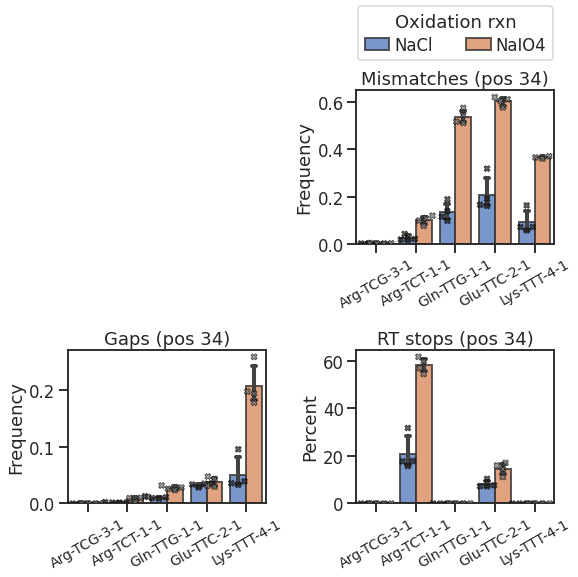

In [37]:
# Plot the mutation/gap/RT stop data for
# position 34 to infer mcm5s2U modification status:
fig = plt.figure(figsize=(8.5, 8.5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

x_order = natsorted(set(df_cat['anno_shorter']))
hue_order = ['NaCl', 'NaIO4']

for dtyp, ax in zip(['mut', 'gap', 'RTstops'], [ax1, ax2, ax3]):
    mask = (df_cat['data_type'] == dtyp)
    g1 = sns.barplot(ax=ax, data=df_cat[mask], x='anno_shorter', y='mut_freq', hue='sample_name_ox', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order, hue_order=hue_order)
    g2 = sns.swarmplot(ax=ax, data=df_cat[mask], x='anno_shorter', y='mut_freq', hue='sample_name_ox', \
                       palette='dark:grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1, order=x_order, legend=False, \
                       hue_order=hue_order)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30, size=14)

    if dtyp == 'RTstops':
        g2.set_ylabel('Percent')
        g2.set_xlabel('')
        g2.set_title('RT stops (pos 34)')
        g1.legend_ = None

    if dtyp == 'mut':
        g2.set_ylabel('Frequency')
        g2.set_xlabel('')
        g2.set_title('Mismatches (pos 34)')
        sns.move_legend(g1, "lower center", bbox_to_anchor=(0.5, 1.17), \
                        ncol=2, title='Oxidation rxn', alignment='center', \
                        labelspacing=0.3, handletextpad=0.3, borderaxespad=0.2, \
                        handlelength=1.5)

    if dtyp == 'gap':
        g2.set_ylabel('Frequency')
        g2.set_xlabel('')
        g2.set_title('Gaps (pos 34)')
        g1.legend_ = None

fig.tight_layout()
fig.savefig('data/transcript_mutations/pos34_mcm5s2U_NoOx-vs-Ox.pdf', bbox_inches='tight')